In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [5]:
# Load the dataset
file_path = "Market.csv"  
df = pd.read_csv(file_path)

In [7]:
# Display the first 5 rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
  Index        Date        Open        High         Low       Close  \
0   NYA  12/31/1965  528.690002  528.690002  528.690002  528.690002   
1   NYA    1/3/1966  527.210022  527.210022  527.210022  527.210022   
2   NYA    1/4/1966  527.840027  527.840027  527.840027  527.840027   
3   NYA    1/5/1966  531.119995  531.119995  531.119995  531.119995   
4   NYA    1/6/1966  532.070007  532.070007  532.070007  532.070007   

    Adj Close  Volume  
0  528.690002     0.0  
1  527.210022     0.0  
2  527.840027     0.0  
3  531.119995     0.0  
4  532.070007     0.0  


In [9]:
# Check column names and data types
print("\nColumn Names and Data Types:")
print(df.dtypes)


Column Names and Data Types:
Index         object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [11]:
# Get summary statistics of numerical columns
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
                Open           High            Low          Close  \
count  110253.000000  110252.000000  110251.000000  110250.000000   
mean     7658.561932    7704.538416    7608.129749    7657.740822   
std      9011.455529    9066.605458    8954.536718    9011.555549   
min        54.869999      54.869999      54.869999      54.869999   
25%      1855.060059    1864.687470    1844.015015    1855.347473   
50%      5194.399902    5226.750000    5154.299805    5194.889892   
75%     10134.299810   10207.827635   10060.369630   10134.867430   
max     68775.062500   69403.750000   68516.992190   68775.062500   

           Adj Close        Volume  
count  110244.000000  1.102530e+05  
mean     7657.982529  1.273975e+09  
std      9011.723572  4.315783e+09  
min        54.869999  0.000000e+00  
25%      1855.057556  0.000000e+00  
50%      5195.699951  4.329000e+05  
75%     10135.512452  1.734314e+08  
max     68775.062500  9.440374e+10  


In [13]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


Missing Values in Each Column:
Index           0
Date            0
Open         2204
High         2205
Low          2206
Close        2207
Adj Close    2213
Volume       2204
dtype: int64


In [15]:
# Display unique values in categorical columns (if any)
categorical_cols = df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    for col in categorical_cols:
        print(f"\nUnique values in '{col}':")
        print(df[col].unique())


Unique values in 'Index':
['NYA' 'IXIC' 'HSI' '000001.SS' 'GSPTSE' '399001.SZ' 'NSEI' 'GDAXI' 'KS11'
 'SSMI' 'TWII' 'J203.JO' 'N225' 'N100']

Unique values in 'Date':
['12/31/1965' '1/3/1966' '1/4/1966' ... '4/13/1979' '5/28/1979' '6/3/2021']


In [19]:
# Identify key features (Assuming stock market data structure)
expected_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
available_columns = [col for col in expected_columns if col in df.columns]

print("\nKey Features Identified in Dataset:")
print(available_columns)


Key Features Identified in Dataset:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


In [21]:
# Convert 'Date' column to datetime format if present
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    print("\nDate column converted to datetime format.")


Date column converted to datetime format.


In [77]:
df = df.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric data to NaN

In [79]:
# Handle missing values (Basic handling: Fill or drop)
if df.isnull().sum().sum() > 0:
    print("\nHandling Missing Values...")
    df = df.dropna()


Handling Missing Values...


In [25]:
print("\nFinal Dataset Shape after cleaning:", df.shape)


Final Dataset Shape after cleaning: (110238, 8)


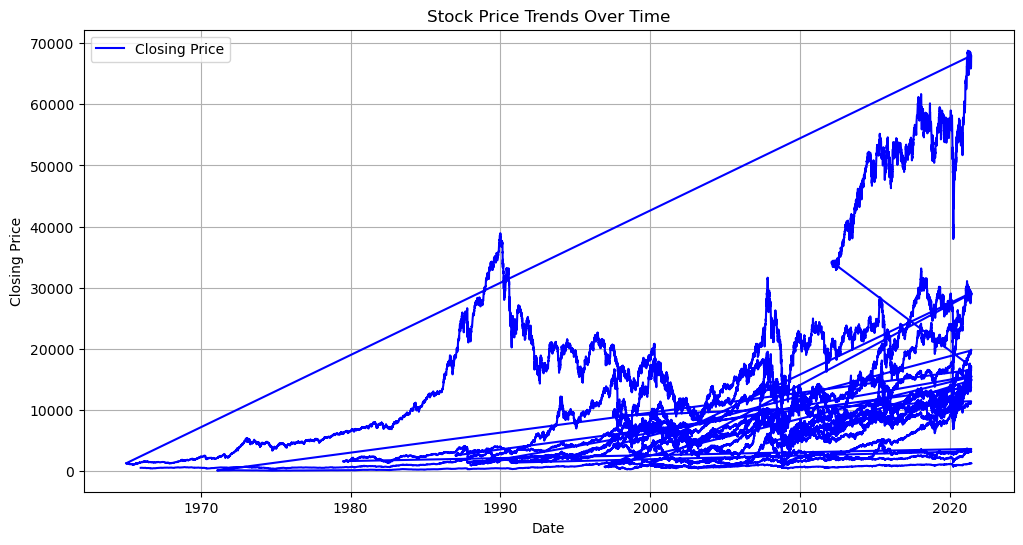

In [31]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Closing Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Price Trends Over Time')
plt.legend()
plt.grid()
plt.show()

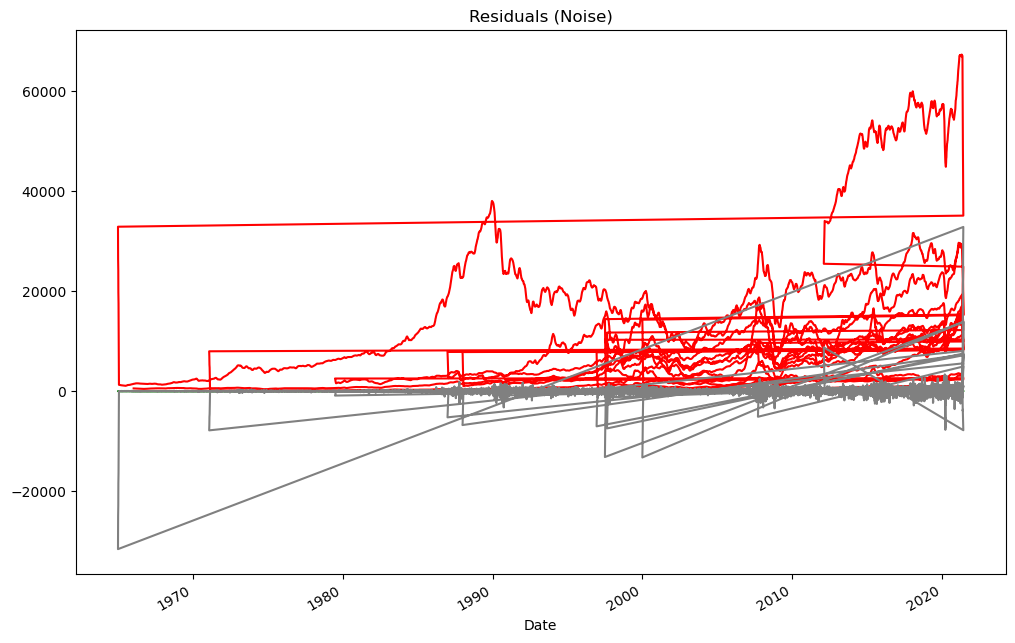

In [33]:
# Check seasonality using decomposition
if 'Close' in df.columns:
    df.set_index('Date', inplace=True)
    decomposition = seasonal_decompose(df['Close'], model='additive', period=30)

    plt.figure(figsize=(12,8))
    decomposition.trend.plot(title='Trend Component', color='red')
    decomposition.seasonal.plot(title='Seasonal Component', color='green')
    decomposition.resid.plot(title='Residuals (Noise)', color='gray')
    plt.show()

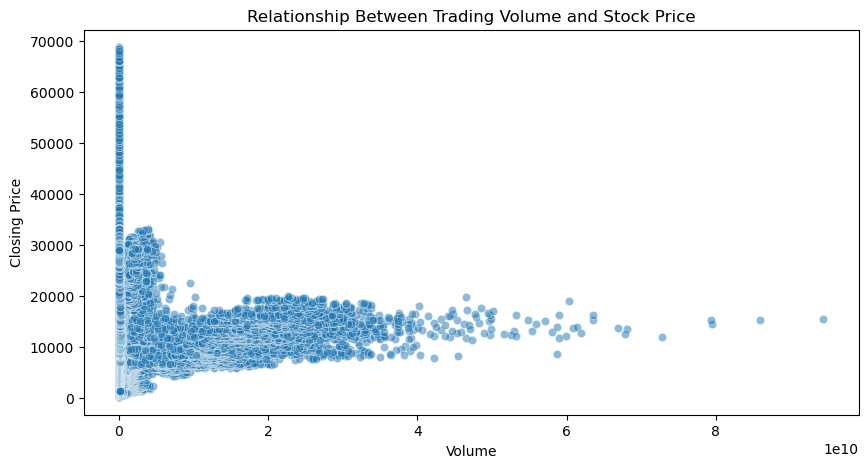

In [35]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=df['Volume'], y=df['Close'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Closing Price')
plt.title('Relationship Between Trading Volume and Stock Price')
plt.show()

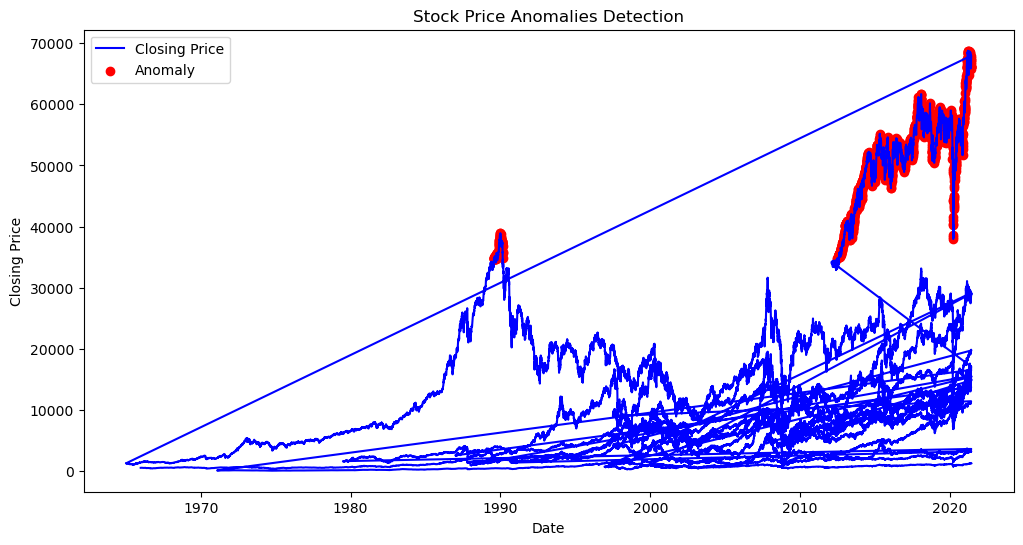

In [37]:
# Use Z-score to detect anomalies
df['Price_ZScore'] = zscore(df['Close'])
df['Anomaly'] = df['Price_ZScore'].apply(lambda x: 'Anomaly' if abs(x) > 3 else 'Normal')

# Plot anomalies
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Closing Price', color='blue')
plt.scatter(df[df['Anomaly'] == 'Anomaly'].index, df[df['Anomaly'] == 'Anomaly']['Close'], color='red', label='Anomaly', marker='o')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Price Anomalies Detection')
plt.legend()
plt.show()

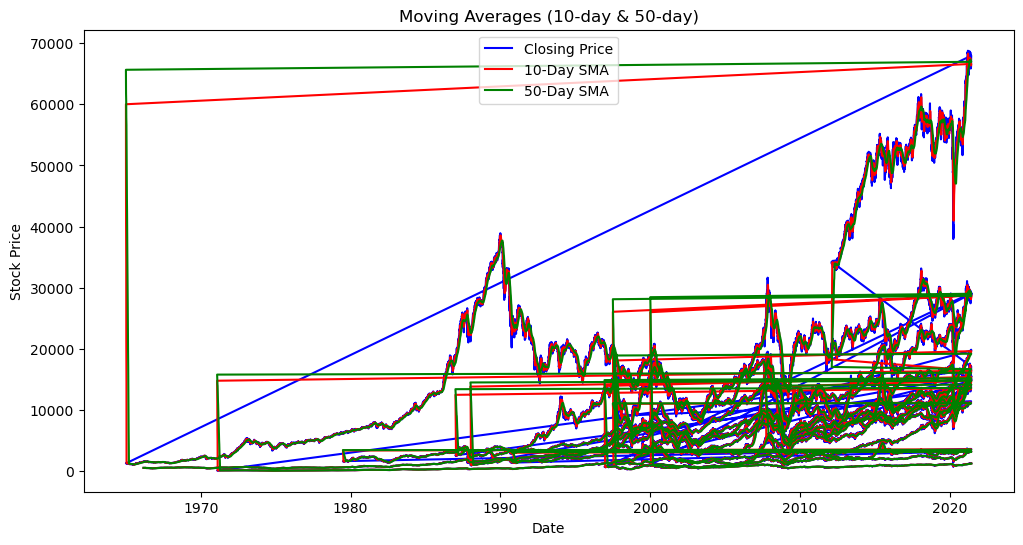

In [39]:
# Create Lag Features
df['Prev_Close'] = df['Close'].shift(1)
df['Price_Change'] = df['Close'] - df['Prev_Close']

# Moving Averages
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Drop NaN values from moving averages
df = df.dropna()

# Plot moving averages
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Closing Price', color='blue')
plt.plot(df.index, df['SMA_10'], label='10-Day SMA', color='red')
plt.plot(df.index, df['SMA_50'], label='50-Day SMA', color='green')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Moving Averages (10-day & 50-day)')
plt.legend()
plt.show()

In [99]:
df = pd.read_csv("market.csv")  # Change file name if needed
print(f"Dataset Loaded: {df.shape}")  # Should not be (0, X)
print(df.head())  # Show first few rows

Dataset Loaded: (112457, 8)
  Index        Date        Open        High         Low       Close  \
0   NYA  12/31/1965  528.690002  528.690002  528.690002  528.690002   
1   NYA    1/3/1966  527.210022  527.210022  527.210022  527.210022   
2   NYA    1/4/1966  527.840027  527.840027  527.840027  527.840027   
3   NYA    1/5/1966  531.119995  531.119995  531.119995  531.119995   
4   NYA    1/6/1966  532.070007  532.070007  532.070007  532.070007   

    Adj Close  Volume  
0  528.690002     0.0  
1  527.210022     0.0  
2  527.840027     0.0  
3  531.119995     0.0  
4  532.070007     0.0  


In [101]:
df = df[df['Close'].notna()]  # This removes all rows if 'Close' is already empty
df = df[df['Volume'] > 0]  # If 'Volume' has only zero/null values, this will remove everything

In [135]:
df = pd.read_csv("market.csv", header=0, encoding="utf-8", delimiter=",")  # Adjust if needed
print(f"Dataset Reloaded: {df.shape}")

Dataset Reloaded: (112457, 8)


Dataset size after cleaning: (110238, 8)
Train size: 88190, Test size: 22048


D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_m

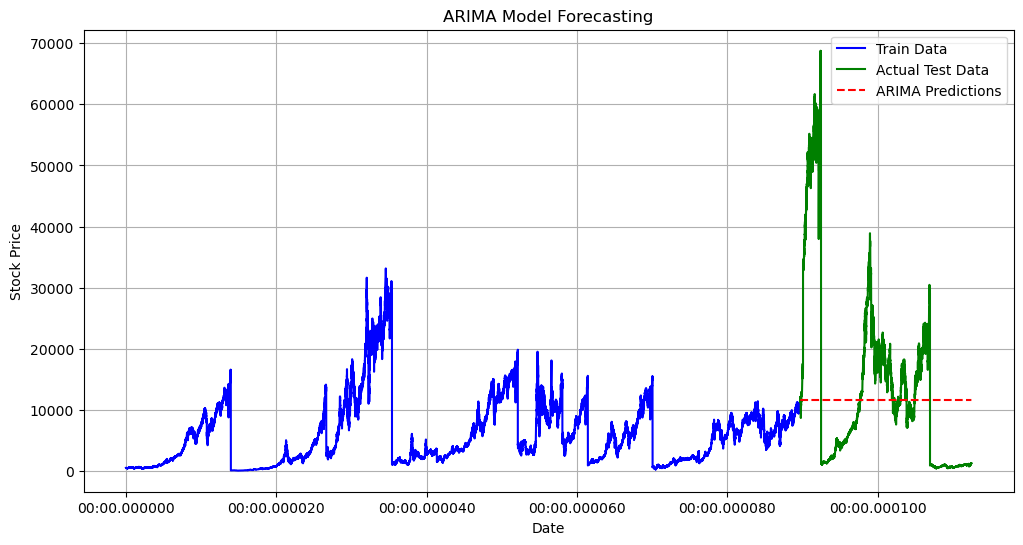

ARIMA MAE: 11117.41
ARIMA RMSE: 15522.38


In [137]:
# Ensure 'Close' column exists and is numeric
if 'Close' not in df.columns:
    raise ValueError("The dataset must have a 'Close' column for ARIMA modeling.")

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to numeric
df.dropna(subset=['Close'], inplace=True)  # Drop NaN values

# Ensure DateTime index
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors='coerce')
    df.dropna(inplace=True)  # Drop rows with invalid dates

# **Check dataset after cleaning**
print(f"Dataset size after cleaning: {df.shape}")
if df.empty:
    raise ValueError("Dataset is empty after cleaning. Check the original data.")

# Ensure dataset is large enough for train-test split
if len(df) < 10:  # Set a minimum size (adjust as needed)
    raise ValueError("Dataset is too small for ARIMA modeling.")

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

# **Check if train/test split is valid**
print(f"Train size: {len(train)}, Test size: {len(test)}")

if train.empty or test.empty:
    raise ValueError("Training or testing set is empty. Increase dataset size or adjust the split ratio.")

# Fit ARIMA model
try:
    model = ARIMA(train, order=(5,1,0))  # (p,d,q) -> Adjust as needed
    arima_model = model.fit()
except Exception as e:
    raise RuntimeError(f"ARIMA model fitting failed: {e}")

# Forecast
forecast = arima_model.forecast(steps=len(test))

# Plot Results
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='green')
plt.plot(test.index, forecast, label='ARIMA Predictions', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ARIMA Model Forecasting')
plt.legend()
plt.grid()
plt.show()

# Calculate error metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'ARIMA MAE: {mae:.2f}')
print(f'ARIMA RMSE: {rmse:.2f}')


22:41:49 - cmdstanpy - INFO - Chain [1] start processing
22:43:03 - cmdstanpy - INFO - Chain [1] done processing


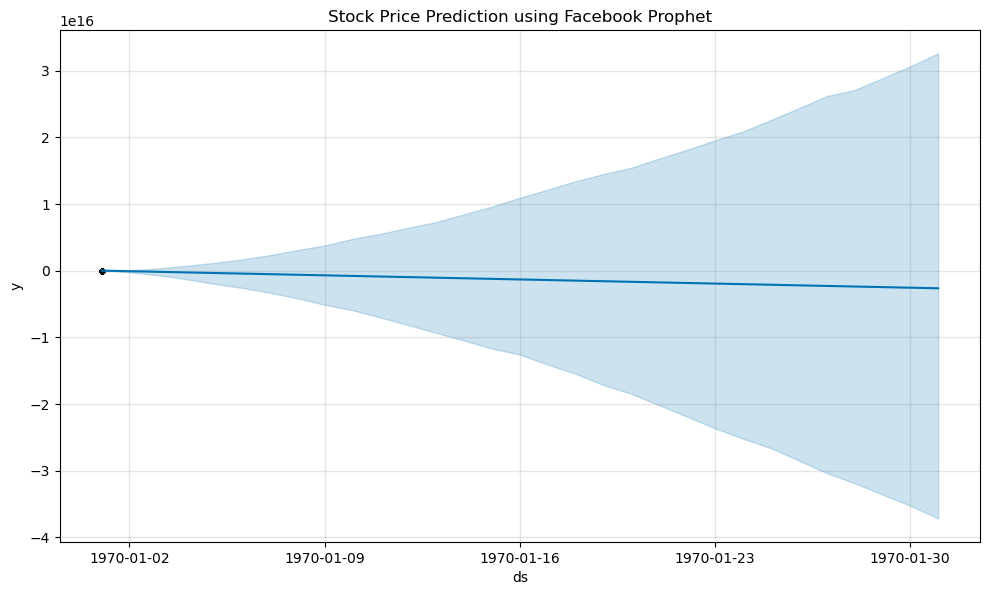

In [143]:
# Ensure 'Close' column exists
if 'Close' not in df.columns:
    raise ValueError("The dataset must have a 'Close' column for Prophet modeling.")

# Keep only date and Close price
df_prophet = df[['Close']].reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (target variable)

# Define and fit model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Create future dataframe
future = prophet_model.make_future_dataframe(periods=30)  # Forecast next 30 days

# Predict
forecast = prophet_model.predict(future)

# Plot results
prophet_model.plot(forecast)
plt.title("Stock Price Prediction using Facebook Prophet")
plt.show()


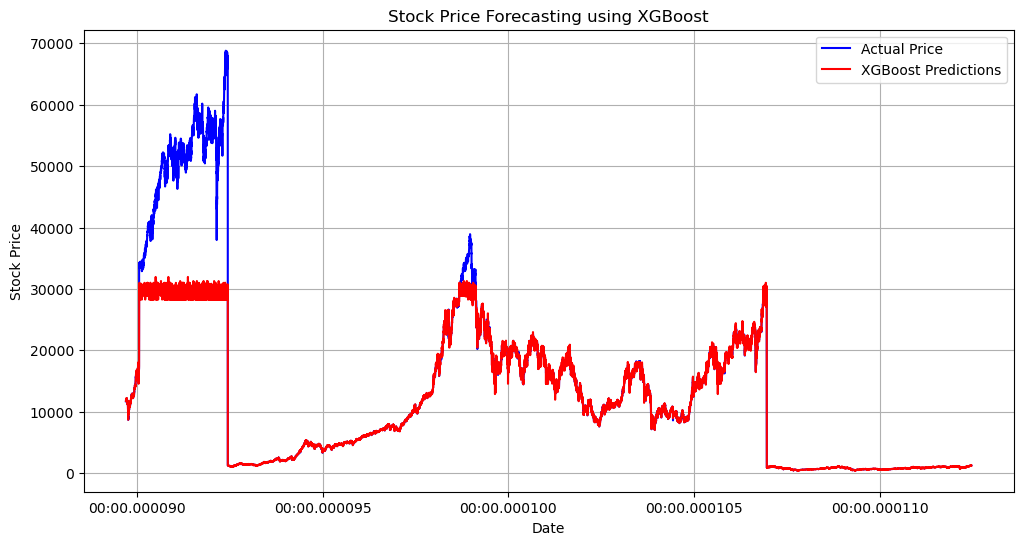

XGBoost MAE: 2410.68
XGBoost RMSE: 7384.38


In [145]:
# Create lag features
df['Prev_Close'] = df['Close'].shift(1)
df['Price_Change'] = df['Close'] - df['Prev_Close']
df = df.dropna()

# Define features and target variable
X = df[['Prev_Close', 'Price_Change']]
y = df['Close']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Plot Results
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(df.index[-len(y_test):], y_pred, label='XGBoost Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Forecasting using XGBoost')
plt.legend()
plt.grid()
plt.show()

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'XGBoost MAE: {mae:.2f}')
print(f'XGBoost RMSE: {rmse:.2f}')


                                    Close
1970-01-01 00:00:00.000000001  527.210022
1970-01-01 00:00:00.000000002  527.840027
1970-01-01 00:00:00.000000003  531.119995
1970-01-01 00:00:00.000000004  532.070007
1970-01-01 00:00:00.000000005  532.599976


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - loss: 1.1752e-04
Epoch 2/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 1.9368e-05
Epoch 3/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 1.0819e-05
Epoch 4/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 1.9115e-05
Epoch 5/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 1.0572e-05
Epoch 6/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 1.6676e-05
Epoch 7/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 8.1134e-06
Epoch 8/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 7.1262e-06
Epoch 9/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 1.0294e-05
Epoch 10/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 1.2081e-05
Epoch 11/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 1.8258e-05
Epoch 12/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 9.6352e-06
Epoch 13/50
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 6.6899e-06
Epoch 14/50
5512/5512 ━━━━━━━━━━━━

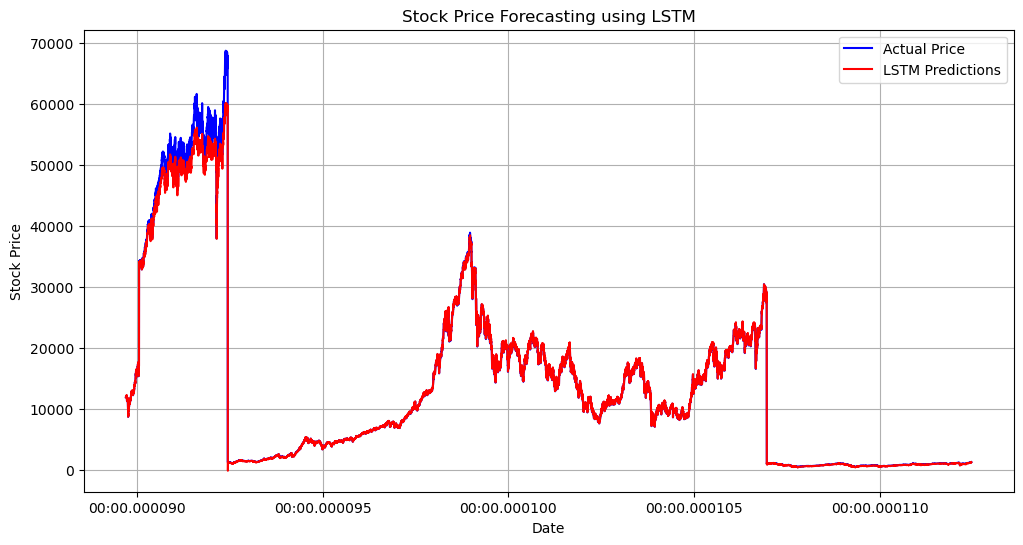

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- Step 1: Select the 'Close' column and ensure it's numeric ---
if 'Close' not in df.columns:
    raise ValueError("The dataset must have a 'Close' column for LSTM modeling.")

# Use only the 'Close' column
data = df[['Close']]
# (Optional) Check the first few rows to verify
print(data.head())

# --- Step 2: Normalize the Data ---
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# --- Step 3: Create Sequences for LSTM ---
def create_sequences(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_sequences(data_scaled, time_step)

# --- Step 4: Split Data into Training and Testing Sets ---
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# --- Step 5: Build and Train the LSTM Model ---
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# --- Step 6: Make Predictions ---
y_pred = model.predict(X_test)

# Convert predictions and actual values back to original scale
y_pred = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Step 7: Plot the Results ---
plt.figure(figsize=(12,6))
# Here, we assume df.index corresponds to the original data's dates.
# Adjust the indexing if necessary.
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual Price', color='blue')
plt.plot(df.index[-len(y_test):], y_pred, label='LSTM Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Forecasting using LSTM')
plt.legend()
plt.grid()
plt.show()

In [153]:
# Load dataset
file_path = "Market.csv"  
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Check dataset
print(df.info())
print(df.describe())

# Use 'Close' price for analysis
df = df[['Close', 'Open', 'High', 'Low', 'Volume']].dropna()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112457 entries, 1965-01-05 to 2021-06-03
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      112457 non-null  object 
 1   Open       110253 non-null  float64
 2   High       110252 non-null  float64
 3   Low        110251 non-null  float64
 4   Close      110250 non-null  float64
 5   Adj Close  110244 non-null  float64
 6   Volume     110253 non-null  float64
dtypes: float64(6), object(1)
memory usage: 6.9+ MB
None
                Open           High            Low          Close  \
count  110253.000000  110252.000000  110251.000000  110250.000000   
mean     7658.561932    7704.538416    7608.129749    7657.740822   
std      9011.455529    9066.605458    8954.536718    9011.555549   
min        54.869999      54.869999      54.869999      54.869999   
25%      1855.060059    1864.687470    1844.015015    1855.347473   
50%      5194.399902    5226.75000

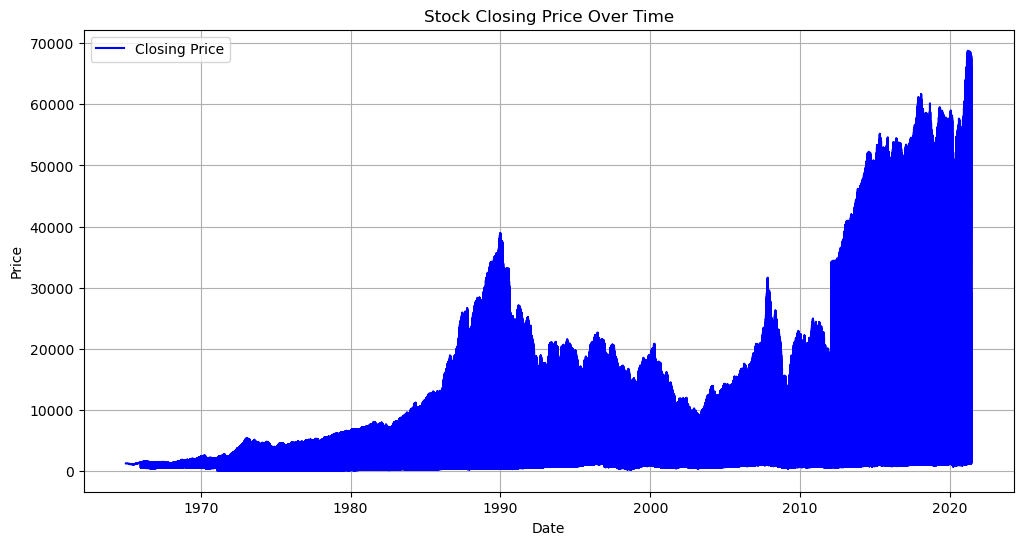

In [155]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label="Closing Price", color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Closing Price Over Time')
plt.legend()
plt.grid()
plt.show()

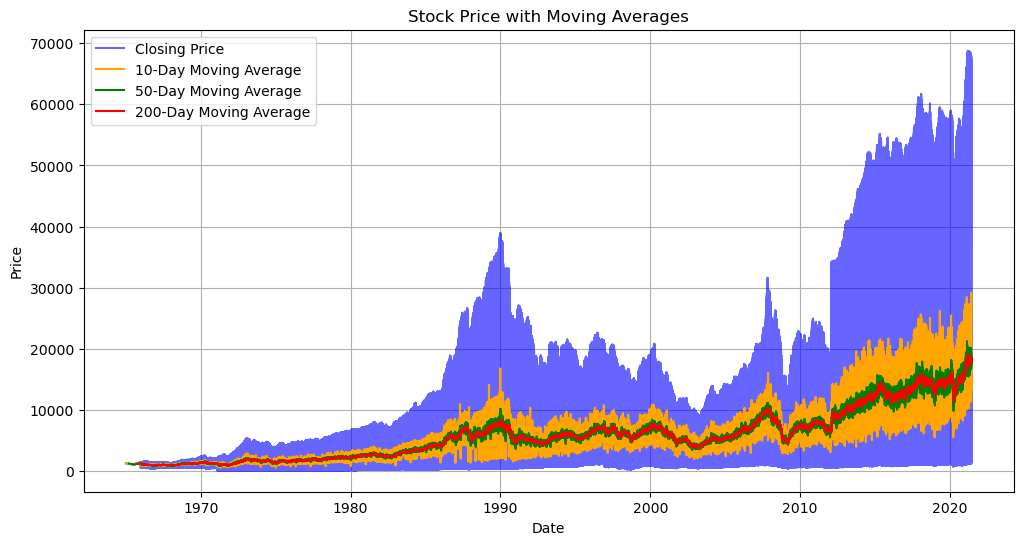

In [157]:
df['10-day MA'] = df['Close'].rolling(window=10).mean()
df['50-day MA'] = df['Close'].rolling(window=50).mean()
df['200-day MA'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label="Closing Price", color='blue', alpha=0.6)
plt.plot(df.index, df['10-day MA'], label="10-Day Moving Average", color='orange')
plt.plot(df.index, df['50-day MA'], label="50-Day Moving Average", color='green')
plt.plot(df.index, df['200-day MA'], label="200-Day Moving Average", color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with Moving Averages')
plt.legend()
plt.grid()
plt.show()

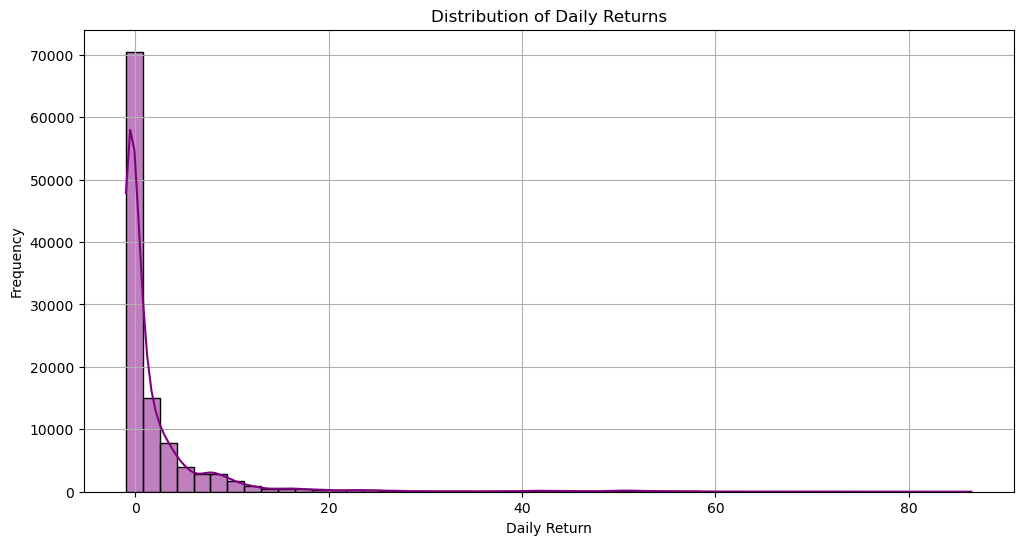

Skewness of Daily Returns: 5.28
Kurtosis of Daily Returns: 34.29


In [159]:
# Calculate daily returns
df['Daily Return'] = df['Close'].pct_change()

# Calculate weekly returns
df['Weekly Return'] = df['Close'].pct_change(7)

# Plot daily returns distribution
plt.figure(figsize=(12,6))
sns.histplot(df['Daily Return'].dropna(), bins=50, kde=True, color='purple')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Returns')
plt.grid()
plt.show()

# Print Skewness and Kurtosis for returns
print(f"Skewness of Daily Returns: {skew(df['Daily Return'].dropna()):.2f}")
print(f"Kurtosis of Daily Returns: {kurtosis(df['Daily Return'].dropna()):.2f}")

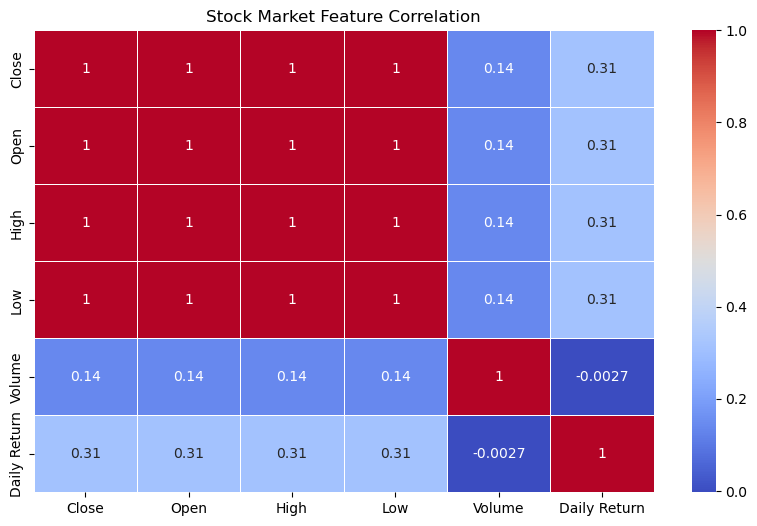

In [161]:
correlation_matrix = df[['Close', 'Open', 'High', 'Low', 'Volume', 'Daily Return']].corr()

# Heatmap of correlation
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Stock Market Feature Correlation')
plt.show()

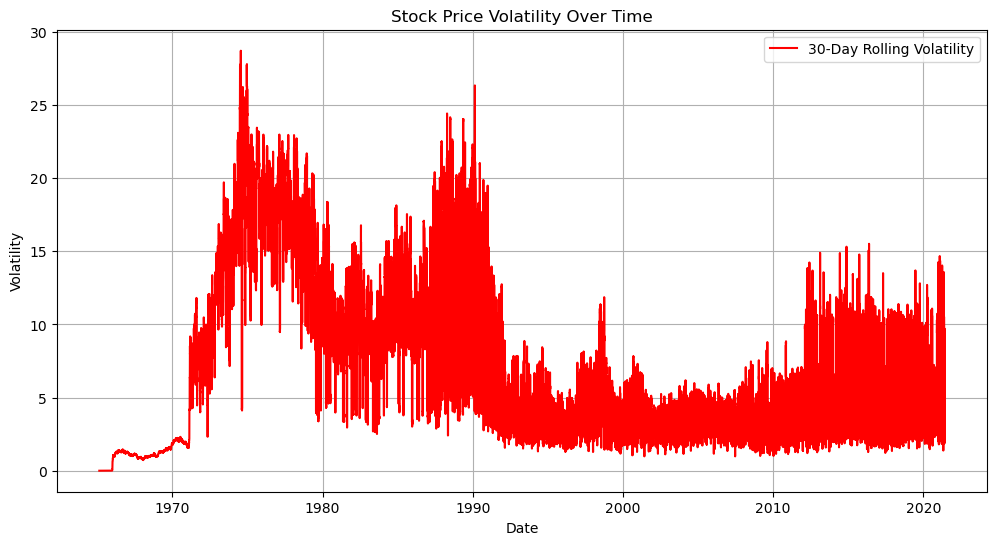

In [163]:
# Calculate rolling standard deviation (volatility)
df['Volatility (30-day)'] = df['Daily Return'].rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Volatility (30-day)'], label="30-Day Rolling Volatility", color='red')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Stock Price Volatility Over Time')
plt.legend()
plt.grid()
plt.show()

In [165]:
# Find the top 5 highest volatility days
high_risk_days = df[['Volatility (30-day)']].nlargest(5, 'Volatility (30-day)')
print("Top 5 High-Risk Days:")
print(high_risk_days)

Top 5 High-Risk Days:
            Volatility (30-day)
Date                           
1974-07-23            28.710618
1974-07-22            27.873873
1974-07-23            27.870616
1974-12-19            27.795917
1974-07-17            27.787570
